# Part 3.9

In [1]:
import os # test commit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy.interpolate import interp2d
from sklearn.metrics import mean_squared_error

try:  # if running with Google Colab
    from google.colab import drive
    drive.mount('/content/drive')

    import sys
    # the location where you saved the tools.py and csv files
    drive_dir = '/content/drive/My Drive/Colab Notebooks/FCTT 3'
    sys.path.insert(0, drive_dir)

    data_dir = os.path.join(drive_dir, 'battery_experimental_data')
    fit_res_dir = os.path.join(drive_dir, 'fitting_results')
except:  # if running locally
    data_dir = os.path.abspath('battery_experimental_data')
    fit_res_dir = os.path.abspath('fitting_results')
    
from tools import *

### Load data

Extract in an array of numpy arrays. Now we add one more dimension, where the first dimension represents the temperature, i.e., [3, N].

For t, I and V_actual for each temperature, pad them with constant values to the same length so that they can be saved as arrays, which is easier for later calculation.

In [2]:
SOC_OCV_data = pd.read_csv(os.path.join(data_dir, 'SOC_OCV_MFCTT_2019.csv'), sep='\t')
training_data_0 = pd.read_csv(os.path.join(data_dir, 'Model_Training_Data_0.csv'))
training_data_20 = pd.read_csv(os.path.join(data_dir, 'Model_Training_Data_20.csv'))
training_data_40 = pd.read_csv(os.path.join(data_dir, 'Model_Training_Data_40.csv'))

In [3]:
ref_SOC = SOC_OCV_data['SOC'].values                   # unit in %
ref_OCV = SOC_OCV_data['Ecell/V'].values               # unit in V
SOC_levels = np.arange(0.9, 0.1, -0.1)
SOC_from_idx_map = {i: SOC_levels[i] for i in range(8)}  # 8 SOC levels
temp_from_idx_map = {0: '$0^oC$', 1: '$20^oC$', 2: '$40^oC$'}  # 3 temperature level


def pad_time(t, max_length):
    N = len(t)
    if N == max_length:
        return t
    interval = t[-1] - t[-2]
    padded_t = np.pad(t, (0, max_length - N), mode='constant', constant_values=(0))
    padded_t[N - max_length:] = np.arange(t[-1] + interval, t[-1] + (max_length-len(t)+1) * interval, interval)
    
    return padded_t

max_length = np.max([len(training_data_0), len(training_data_20), len(training_data_40)])
t = [pad_time(training_data_0['Time (s)'].values, max_length), 
     pad_time(training_data_20['Time (s)'].values, max_length), 
     pad_time(training_data_40['Time (s)'].values, max_length)]
I = [np.pad(training_data_0['Current (A)'], (0, max_length - len(training_data_0)), mode='edge'),
     np.pad(training_data_20['Current (A)'], (0, max_length - len(training_data_20)), mode='edge'),
     np.pad(training_data_40['Current (A)'], (0, max_length - len(training_data_40)), mode='edge')]
V_actual = [np.pad(training_data_0['Voltage (V)'], (0, max_length - len(training_data_0)), mode='edge'),
            np.pad(training_data_20['Voltage (V)'], (0, max_length - len(training_data_20)), mode='edge'),
            np.pad(training_data_40['Voltage (V)'], (0, max_length - len(training_data_40)), mode='edge')]
t = np.array(t)                            # unit in s
I = -np.array(I)                           # unit in A
V_actual = np.array(V_actual)              # unit in V

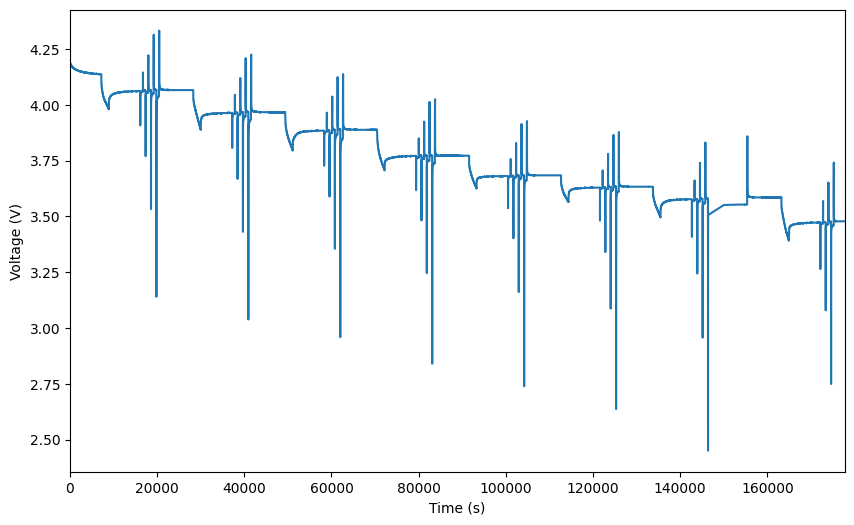

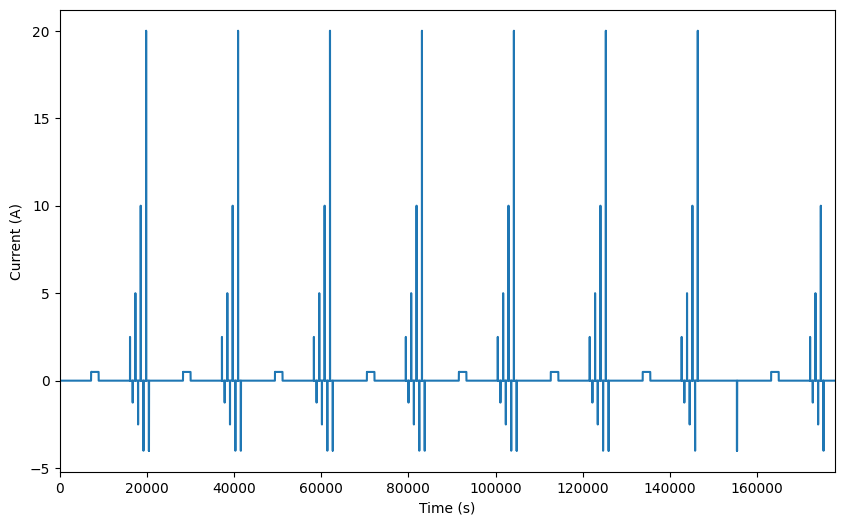

In [4]:
which_temp = 0  # 0 if 0 degC, 1 if 20 degC, 2 if 40 degC
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t[which_temp], V_actual[which_temp])
ax.set_xlim([0, t[which_temp, -1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')

_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t[which_temp], I[which_temp])
ax.set_xlim([0, t[which_temp, -1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Current (A)')

plt.show()

### Splitting Pulses

The idx arrays now have shapes of [3, 8, 8], i.e., [temperatures, SOCs, Current]

In [5]:
idx_pulse_start = np.ndarray((3, 8, 8), dtype='int')
idx_pulse_end = np.ndarray((3, 8, 8), dtype='int')

for i in range(3):
    # shift to left by one index (now i is equivalent to i+1)
    I_shifted = np.concatenate((I[i, 1:], [0]))
    idx_start = np.flatnonzero((I[i] == 0) & (np.abs(I_shifted) > 1))
    idx_end = np.flatnonzero((np.abs(I[i]) > 1) & (I_shifted == 0)) + 1
    
    # if there are less than 8*8=64 points, pad with the last value to size 64
    # (because 0 deg has only 6 pulses at the last SOC)
    idx_start = np.pad(idx_start, (0, 64 - len(idx_start)), mode='edge')
    idx_end = np.pad(idx_end, (0, 64 - len(idx_end)), mode='edge')

    # reshape to 8 x 8 matrix, where rows correspond to each SOC value and
    #                                cols correspond to each pulse with different current
    idx_pulse_start[i] = idx_start.reshape(8, 8)
    idx_pulse_end[i] = idx_end.reshape(8, 8)

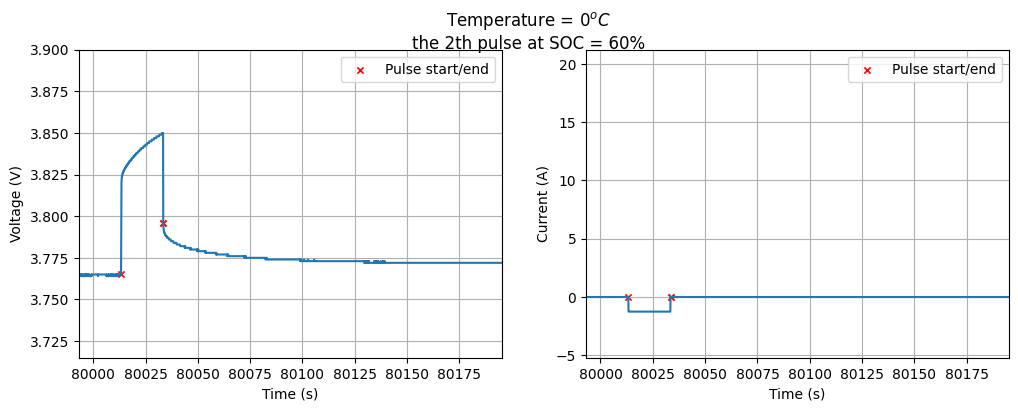

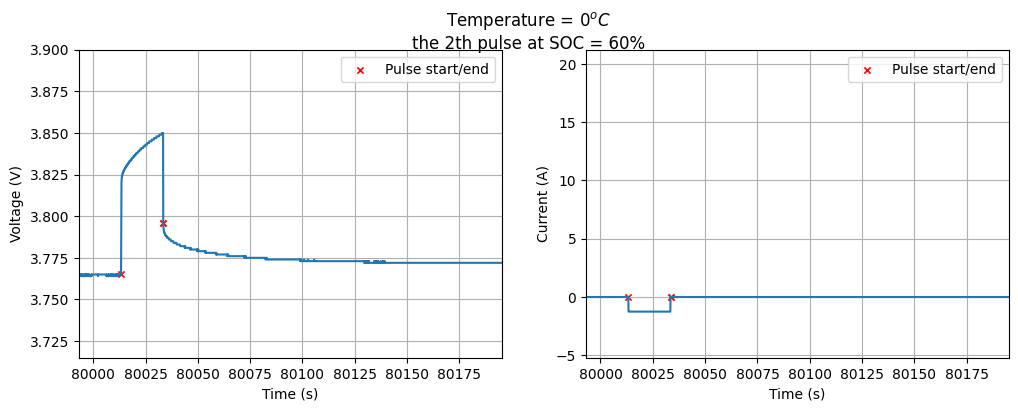

In [6]:
which_temp = 0
which_SOC = 4
which_pulse = 2
plot_pulses(t, I, V_actual, idx_pulse_start, idx_pulse_end,
            which_SOC, which_pulse, show_current=True, temperature=which_temp)

Find index of steady-state voltage for each pulse:

In [7]:
idx_Vss = find_Vss_pos(t, V_actual, idx_pulse_start, idx_pulse_end)

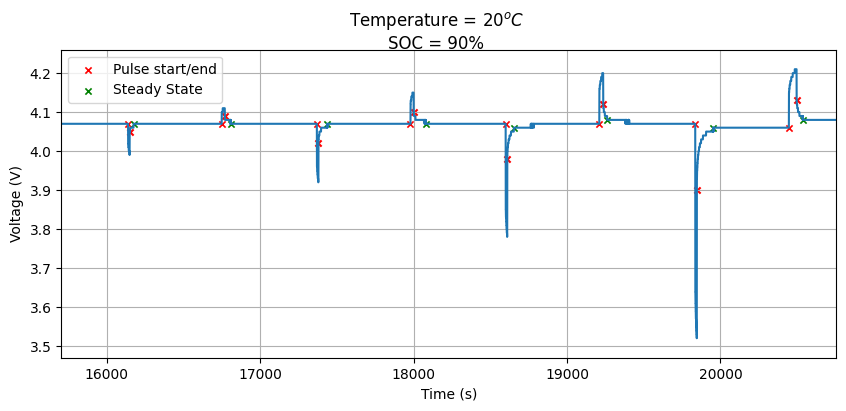

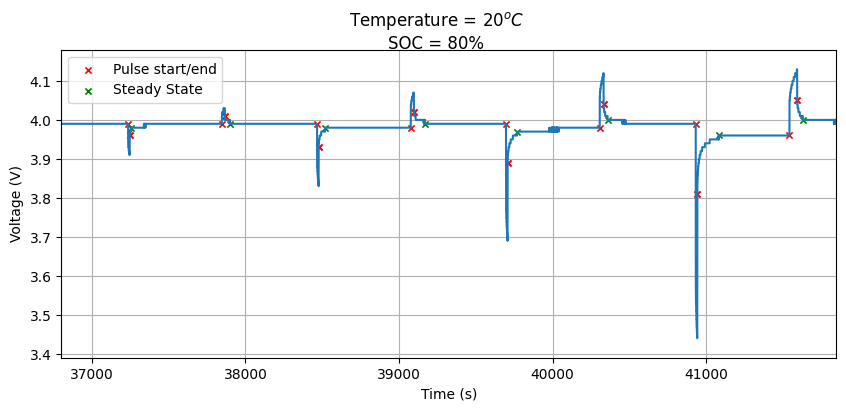

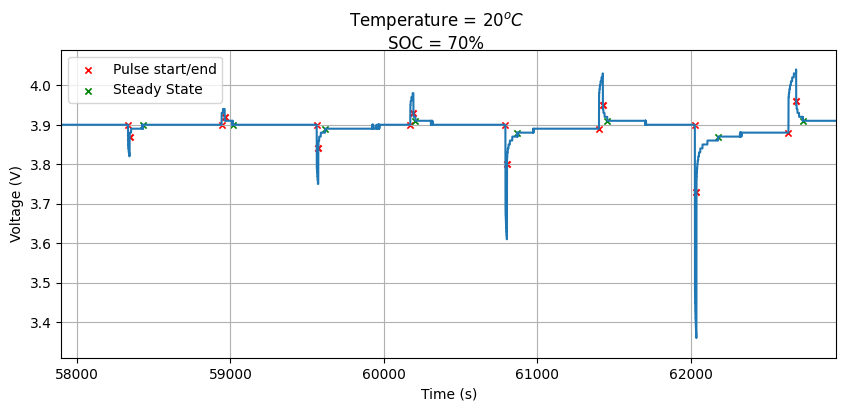

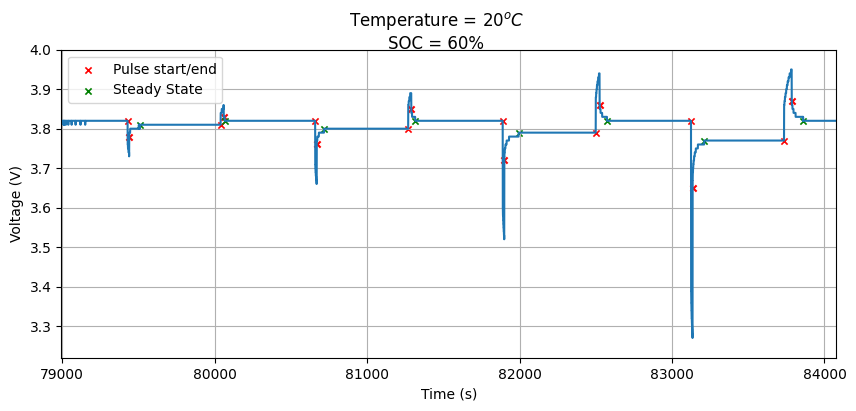

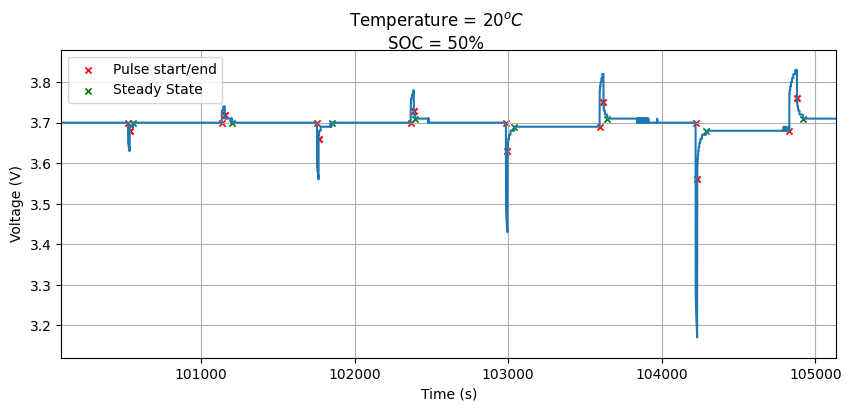

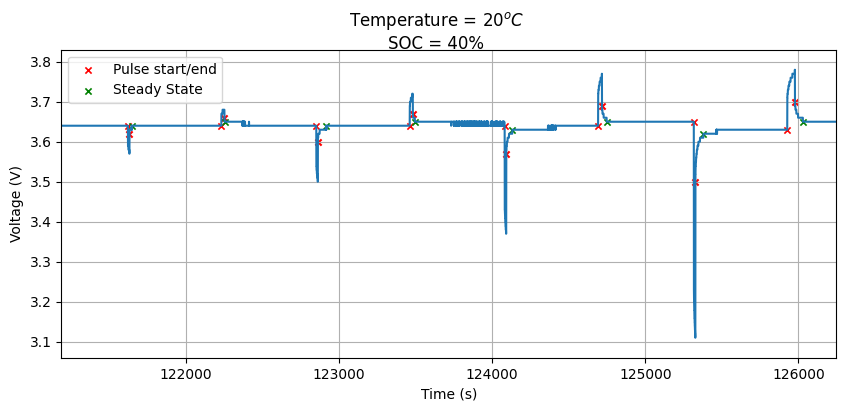

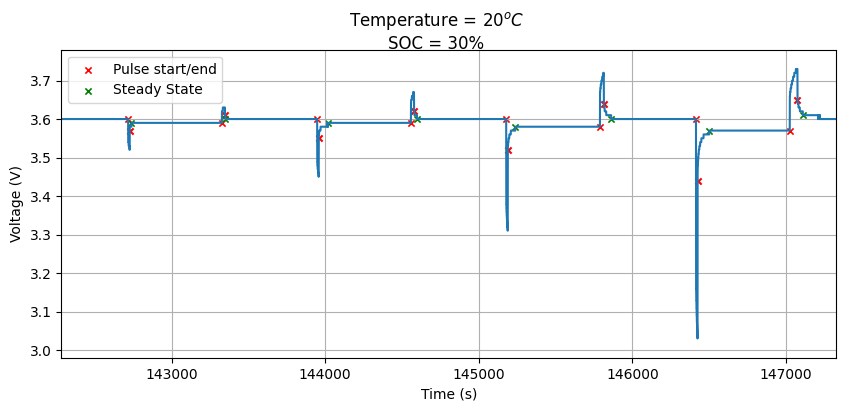

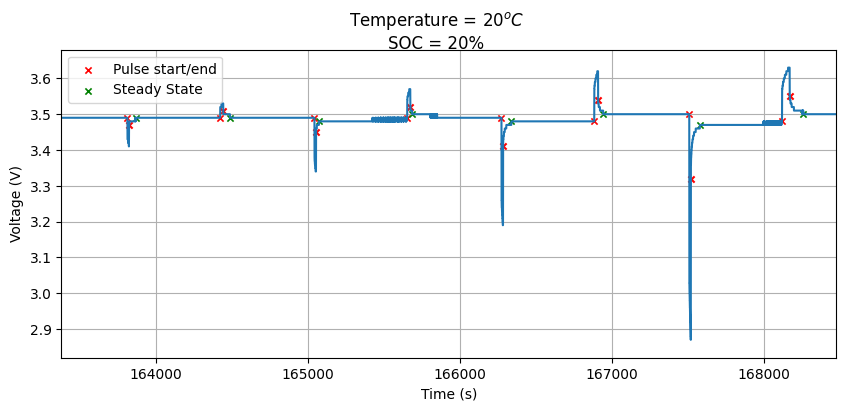

In [8]:
# check all steady state:
show_temp = 1
for show_SOC in np.arange(1, 9):
    show_pulse = 'all'
    plot_pulses(t, I, V_actual, idx_pulse_start, idx_pulse_end,
                show_SOC, show_pulse, idx_Vss, show_current=False, temperature=show_temp)

# show_temp = 2
# show_SOC = 1
# show_pulse = 1
# plot_pulses(t, I, V_actual, idx_pulse_start, idx_pulse_end,
#             show_SOC, show_pulse, idx_Vss, show_current=False, temperature=show_temp)


### Parametrisation

In [9]:
R0_tab, R1_tab, C1_tab, I_peaks, d_I, d_Vinf = para_RC(t, I, V_actual, idx_pulse_end, idx_Vss)
C1_const = read_fit_res(fit_res_dir, 'C1')  # from part 2a

# Visualisation:
rows = pd.MultiIndex.from_product([['%d%%' % (SOC_from_idx_map[i]*100) for i in range(8)],
                                   np.arange(1, 9)],
                                   names=['SOC', 'Pulse'])

df0 = pd.DataFrame({'$I$ $(A)$': I_peaks[0].flatten(),
                    '$R_0$ $(\Omega)$': R0_tab[0].flatten(),
                    '$R_1$ $(\Omega)$': R1_tab[0].flatten(),
                    '$C_1$ $(F)$': np.round(C1_const, 1)}, index=rows)
df0.iloc[-2:] = np.nan  # only 6 pulses here

df20 = pd.DataFrame({'$I$ $(A)$': I_peaks[1].flatten(),
                     '$R_0$ $(\Omega)$': R0_tab[1].flatten(),
                     '$R_1$ $(\Omega)$': R1_tab[1].flatten(),
                     '$C_1$ $(F)$': np.round(C1_const, 1)}, index=rows)

df40 = pd.DataFrame({'$I$ $(A)$': I_peaks[2].flatten(),
                     '$R_0$ $(\Omega)$': R0_tab[2].flatten(),
                     '$R_1$ $(\Omega)$': R1_tab[2].flatten(),
                     '$C_1$ $(F)$': np.round(C1_const, 1)}, index=rows)

# For display:
table1 = df0.to_html()
table2 = df20.to_html()
table3 = df40.to_html()

# Concatenate the HTML tables horizontally
html = '<table style="display:inline-block;"><tr><th>T = 0 degC</th></tr><tr><td>{0}</td></tr></table>'.format(table1)
html += '<table style="display:inline-block;"><tr><th>T = 20 degC</th></tr><tr><td>{0}</td></tr></table>'.format(table2)
html += '<table style="display:inline-block;"><tr><th>T = 40 degC</th></tr><tr><td>{0}</td></tr></table>'.format(table3)
display(HTML(html))

### Plots

#### R1 vs SOC

Plot the value for $R_1$ at $0^oC$ and $-20A$ as a function of SOC.

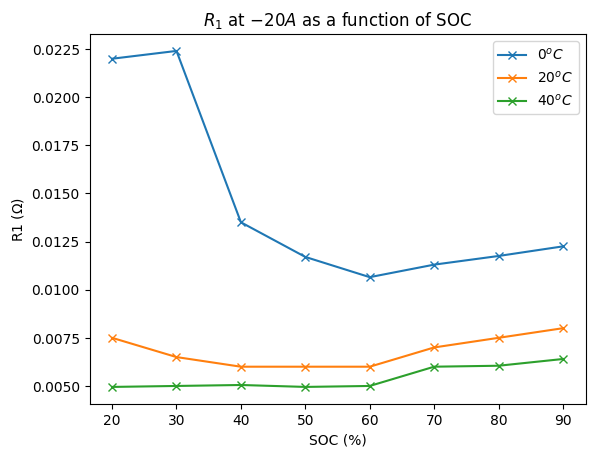

In [10]:
idx_20 = np.where(np.abs(I_peaks[0, 0]-(20)) < 0.01)[0][0]
SOC_plot = np.arange(0.9, 0.1, -0.1) * 100
R1_plot0 = R1_tab[0, :, idx_20]
R1_plot20 = R1_tab[1, :, idx_20]
R1_plot40 = R1_tab[2, :, idx_20]

plt.plot(SOC_plot, R1_plot0, '-x', label='$0^oC$')
plt.plot(SOC_plot, R1_plot20, '-x', label='$20^oC$')
plt.plot(SOC_plot, R1_plot40, '-x', label='$40^oC$')
plt.xlabel('SOC (%)')
plt.ylabel('R1 ($\Omega$)')
plt.legend()
plt.title('$R_1$ at $-20A$ as a function of SOC')
plt.show()

#### Constants

In [11]:
T0 = 20

idx_20 = np.where(np.abs(I_peaks[0, 0]-(20)) < 0.01)[0][0]

x = [0, 20, 40]

R1_true30 = R1_tab[:, 6, idx_20]
R1_true60 = R1_tab[:, 3, idx_20]
R1_true90 = R1_tab[:, 0, idx_20]

#### Fit at 60%

Fit R1 at $60\%$ SOC and $-20A$ to the Arrhenius Equation as a function of temperature.

In [12]:
T_fit = [0, 20, 40]

Fitted parameters:
E: -17839.148216310547

Constants:
R: 8.3145
T0: 20


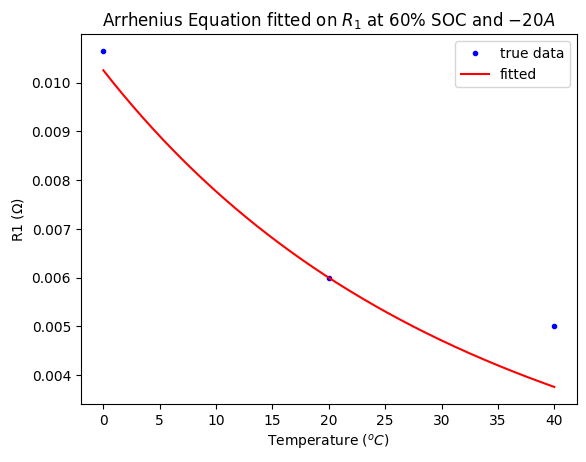

In [13]:
R1_T0 = R1_tab[1, 3, idx_20]
def Arrhenius(T_fit, E):
    return R1_T0 * np.exp(- E/8.3145 * (1/(T_fit+273.15) - 1/(T0+273.15)))

y_true = R1_true60
my_func = Arrhenius
popts, x_plot, y_pred60 = fit_RC(T_fit, y_true, my_func)

print('Fitted parameters:')
print('E:', popts[0])
print('\nConstants:')
print('R:', 8.3145)
print('T0:', T0)

plt.plot(x, y_true, 'b.', label='true data')
plt.plot(x_plot, y_pred60, 'r-', label='fitted')
plt.legend()
plt.xlabel('Temperature ($^oC$)')
plt.ylabel('R1 ($\Omega$)')
plt.title('Arrhenius Equation fitted on $R_1$ at $60\%$ SOC and $-20A$')
plt.show()

Plot the value of $R_1$ at $-20A$ as a function of temperature, at $30\%$ SOC and $90\%$ separately. 

And fit them into the equation obtained from step d.

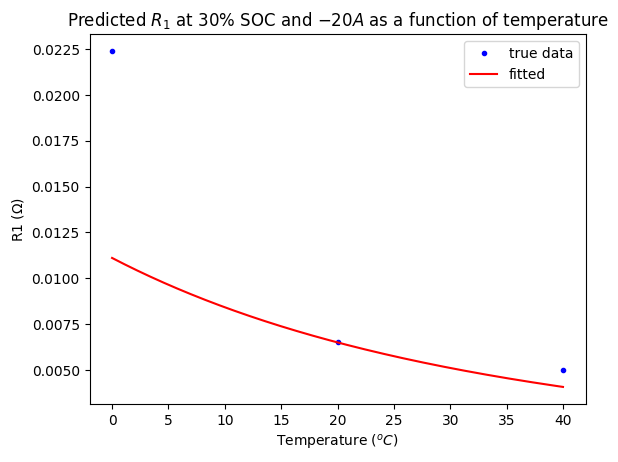

In [14]:
# SOC = 30%
R1_T0 = R1_tab[1, 6, idx_20]
def Arrhenius(T_fit, E):
    return R1_T0 * np.exp(- E/8.3145 * (1/(T_fit+273.15) - 1/(T0+273.15)))

y_true = R1_true30
y_pred30 = Arrhenius(x_plot, *popts)

plt.plot(x, y_true, 'b.', label='true data')
plt.plot(x_plot, y_pred30, 'r-', label='fitted')
plt.legend()
plt.xlabel('Temperature ($^oC$)')
plt.ylabel('R1 ($\Omega$)')
plt.title('Predicted $R_1$ at $30\%$ SOC and $-20A$ as a function of temperature')
plt.show()

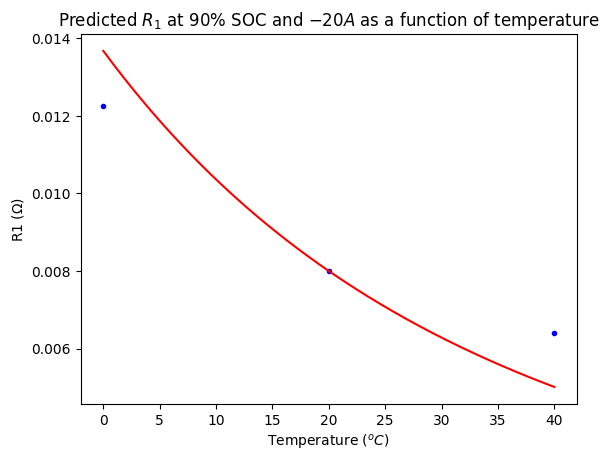

In [15]:
# SOC = 90%
R1_T0 = R1_tab[1, 0, idx_20]
def Arrhenius(T_fit, E):
    return R1_T0 * np.exp(- E/8.3145 * (1/(T_fit+273.15) - 1/(T0+273.15)))

y_true = R1_true90
y_pred90 = Arrhenius(x_plot, *popts)

plt.plot(x, y_true, 'b.', label='true data')
plt.plot(x_plot, y_pred90, 'r-', label='fitted')
plt.xlabel('Temperature ($^oC$)')
plt.ylabel('R1 ($\Omega$)')
plt.title('Predicted $R_1$ at $90\%$ SOC and $-20A$ as a function of temperature')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


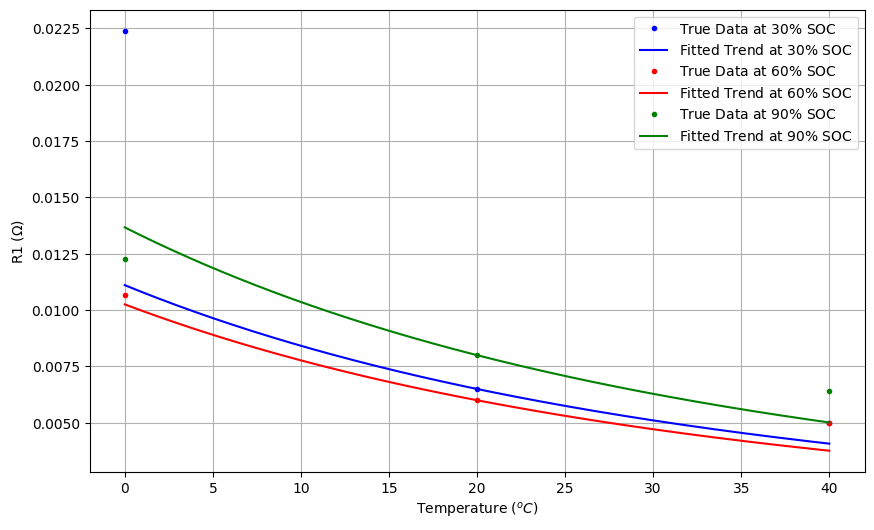

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, R1_true30, 'b.', label='True Data at $30\%$ SOC')
ax.plot(x_plot, y_pred30, 'b-', label='Fitted Trend at $30\%$ SOC')

ax.plot(x, R1_true60, 'r.', label='True Data at $60\%$ SOC')
ax.plot(x_plot, y_pred60, 'r-', label='Fitted Trend at $60\%$ SOC')

ax.plot(x, R1_true90, 'g.', label='True Data at $90\%$ SOC')
ax.plot(x_plot, y_pred90, 'g-', label='Fitted Trend at $90\%$ SOC')
ax.legend()
ax.set_xlabel('Temperature ($^oC$)')
ax.set_ylabel('R1 ($\Omega$)')
ax.grid()
fig.savefig('part3.9_60fitall.eps', format='eps')
plt.show()

#### Fit at 60% through $20^oC$ and $40^oC$ points

Fit R1 at $60\%$ SOC and $-20A$ to the Arrhenius Equation as a function of temperature.

In [17]:
T_fit = [20, 40]

x_plot = np.linspace(0, 40, 500)

Fitted parameters:
E: -6958.032886230611


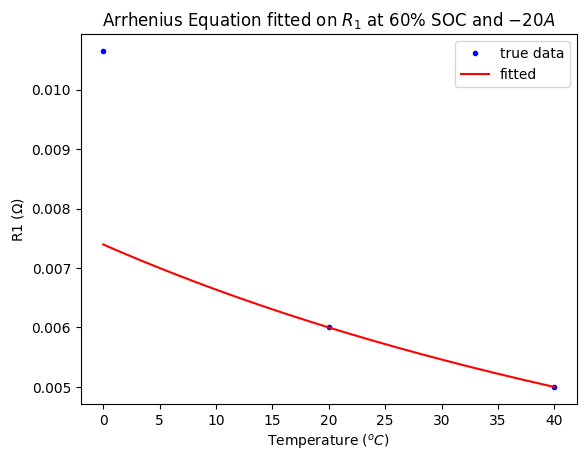

In [18]:
R1_T0 = R1_tab[1, 3, idx_20]
def Arrhenius(T_fit, E):
    return R1_T0 * np.exp(- E/8.3145 * (1/(T_fit+273.15) - 1/(T0+273.15)))

y_true = R1_true60[1:]
my_func = Arrhenius
popts, _, _ = fit_RC(T_fit, y_true, my_func)

y_pred60 = Arrhenius(x_plot, *popts)

print('Fitted parameters:')
print('E:', popts[0])


plt.plot(x, R1_true60, 'b.', label='true data')
plt.plot(x_plot, y_pred60, 'r-', label='fitted')
plt.legend()
plt.xlabel('Temperature ($^oC$)')
plt.ylabel('R1 ($\Omega$)')
plt.title('Arrhenius Equation fitted on $R_1$ at $60\%$ SOC and $-20A$')
plt.show()

Plot the value of $R_1$ at $-20A$ as a function of temperature, at $30\%$ SOC and $90\%$ separately. 

And fit them into the equation obtained from step d.

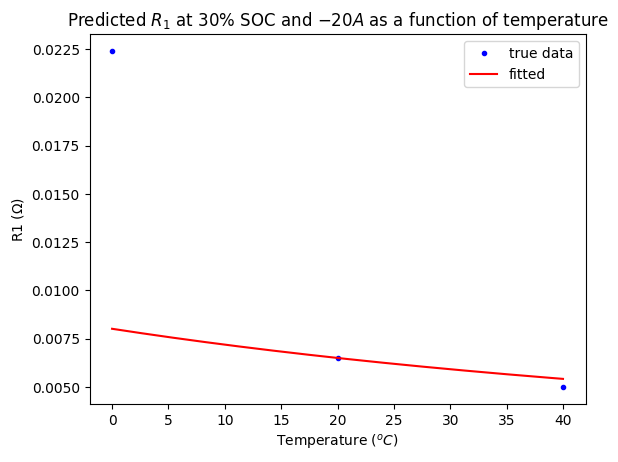

In [19]:
# SOC = 30%
R1_T0 = R1_tab[1, 6, idx_20]
def Arrhenius(T_fit, E):
    return R1_T0 * np.exp(- E/8.3145 * (1/(T_fit+273.15) - 1/(T0+273.15)))

y_pred30 = Arrhenius(x_plot, *popts)

plt.plot(x, R1_true30, 'b.', label='true data')
plt.plot(x_plot, y_pred30, 'r-', label='fitted')
plt.legend()
plt.xlabel('Temperature ($^oC$)')
plt.ylabel('R1 ($\Omega$)')
plt.title('Predicted $R_1$ at $30\%$ SOC and $-20A$ as a function of temperature')
plt.show()

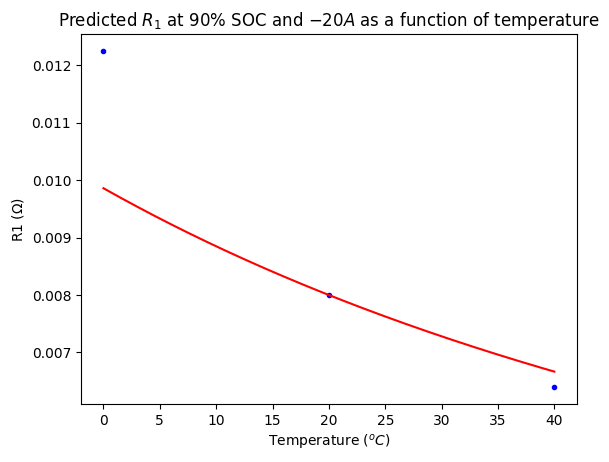

In [20]:
# SOC = 90%
R1_T0 = R1_tab[1, 0, idx_20]
def Arrhenius(T_fit, E):
    return R1_T0 * np.exp(- E/8.3145 * (1/(T_fit+273.15) - 1/(T0+273.15)))

y_pred90 = Arrhenius(x_plot, *popts)

plt.plot(x, R1_true90, 'b.', label='true data')
plt.plot(x_plot, y_pred90, 'r-', label='fitted')
plt.xlabel('Temperature ($^oC$)')
plt.ylabel('R1 ($\Omega$)')
plt.title('Predicted $R_1$ at $90\%$ SOC and $-20A$ as a function of temperature')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


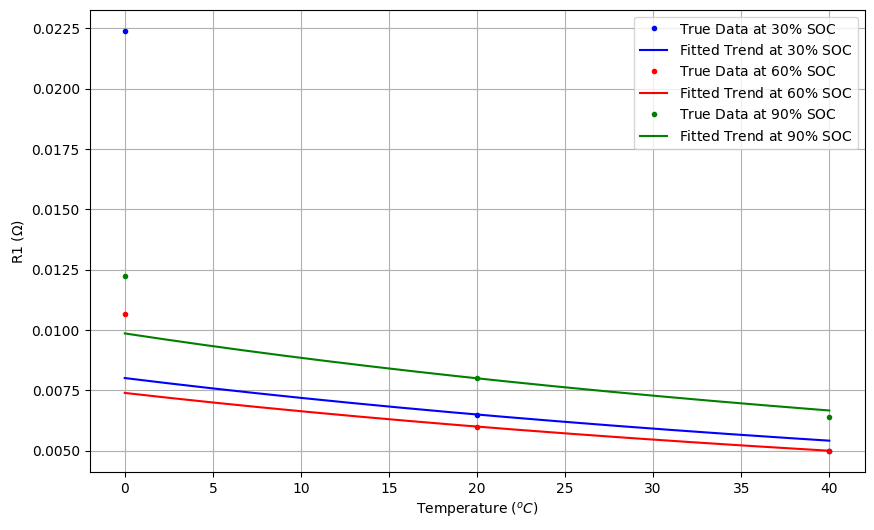

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, R1_true30, 'b.', label='True Data at $30\%$ SOC')
ax.plot(x_plot, y_pred30, 'b-', label='Fitted Trend at $30\%$ SOC')

ax.plot(x, R1_true60, 'r.', label='True Data at $60\%$ SOC')
ax.plot(x_plot, y_pred60, 'r-', label='Fitted Trend at $60\%$ SOC')

ax.plot(x, R1_true90, 'g.', label='True Data at $90\%$ SOC')
ax.plot(x_plot, y_pred90, 'g-', label='Fitted Trend at $90\%$ SOC')
ax.legend()
ax.set_xlabel('Temperature ($^oC$)')
ax.set_ylabel('R1 ($\Omega$)')
ax.grid()
fig.savefig('part3.9_60fit2last.eps', format='eps')
plt.show()

#### Fit at each SOC through $20^oC$ and $40^oC$ points

In [22]:
T_fit = [20, 40]

x_plot = np.linspace(0, 40, 500)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fitted parameters:
E: -10012.7445840075


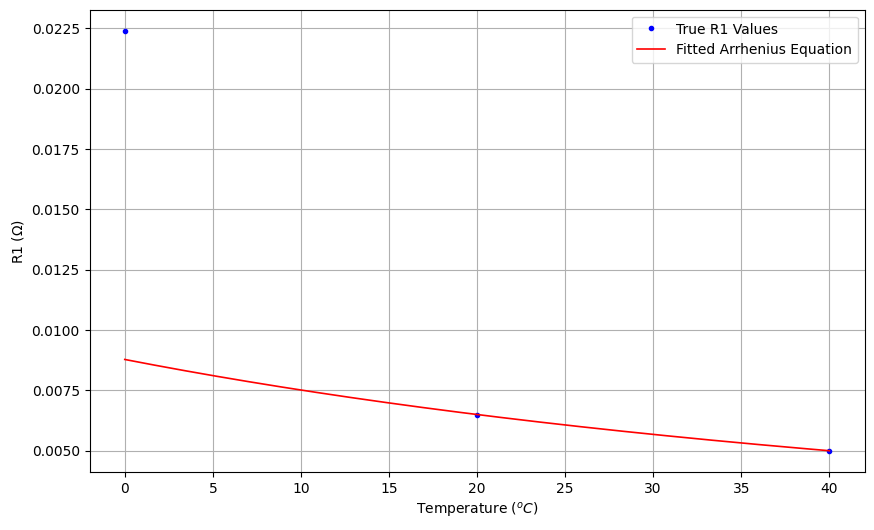

In [23]:
# SOC = 30%
R1_T0 = R1_tab[1, 6, idx_20]
def Arrhenius(T_fit, E):
    return R1_T0 * np.exp(- E/8.3145 * (1/(T_fit+273.15) - 1/(T0+273.15)))

y_true = R1_true30[1:]
my_func = Arrhenius
popts, _, _ = fit_RC(T_fit, y_true, my_func)

y_pred30 = Arrhenius(x_plot, *popts)

print('Fitted parameters:')
print('E:', popts[0])


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, R1_true30, 'b.', label='True R1 Values')
ax.plot(x_plot, y_pred30, 'r-', label='Fitted Arrhenius Equation', linewidth=1.2)
ax.legend()
ax.set_xlabel('Temperature ($^oC$)')
ax.set_ylabel('R1 ($\Omega$)')
ax.grid()
fig.savefig('part3.9_30soc.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fitted parameters:
E: -6958.032886230611


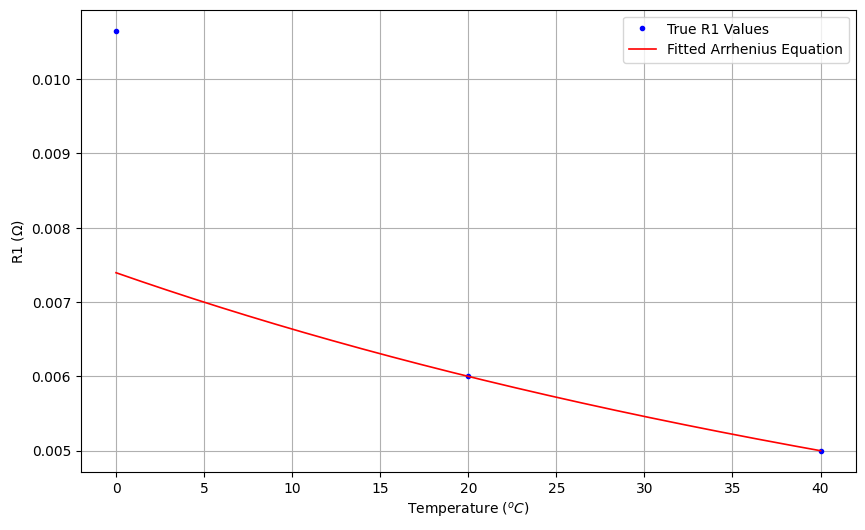

In [24]:
# SOC 60%
R1_T0 = R1_tab[1, 3, idx_20]
def Arrhenius(T_fit, E):
    return R1_T0 * np.exp(- E/8.3145 * (1/(T_fit+273.15) - 1/(T0+273.15)))

y_true = R1_true60[1:]
my_func = Arrhenius
popts, _, _ = fit_RC(T_fit, y_true, my_func)

y_pred60 = Arrhenius(x_plot, *popts)

print('Fitted parameters:')
print('E:', popts[0])


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, R1_true60, 'b.', label='True R1 Values')
ax.plot(x_plot, y_pred60, 'r-', label='Fitted Arrhenius Equation', linewidth=1.2)
ax.legend()
ax.set_xlabel('Temperature ($^oC$)')
ax.set_ylabel('R1 ($\Omega$)')
ax.grid()
fig.savefig('part3.9_60soc.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fitted parameters:
E: -8514.035780237638


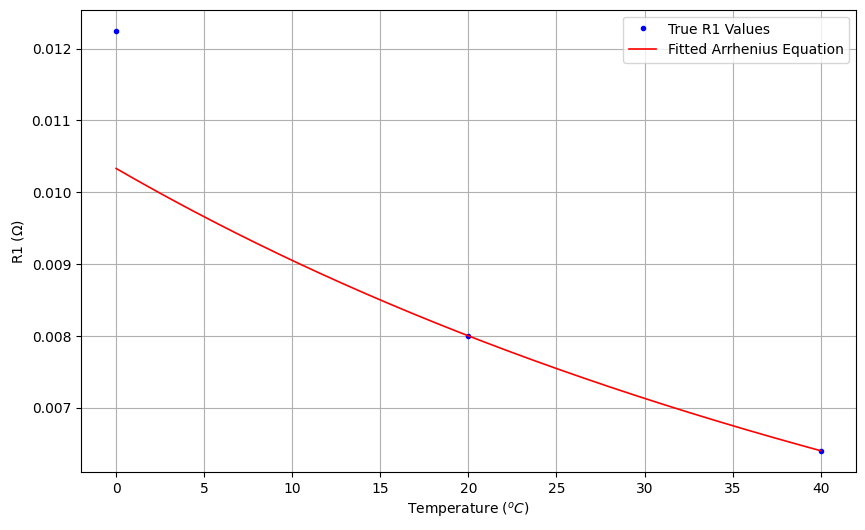

In [25]:
# SOC = 90%
R1_T0 = R1_tab[1, 0, idx_20]
def Arrhenius(T_fit, E):
    return R1_T0 * np.exp(- E/8.3145 * (1/(T_fit+273.15) - 1/(T0+273.15)))

y_true = R1_true90[1:]
my_func = Arrhenius
popts, _, _ = fit_RC(T_fit, y_true, my_func)

y_pred90 = Arrhenius(x_plot, *popts)

print('Fitted parameters:')
print('E:', popts[0])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, R1_true90, 'b.', label='True R1 Values')
ax.plot(x_plot, y_pred90, 'r-', label='Fitted Arrhenius Equation', linewidth=1.2)
ax.legend()
ax.set_xlabel('Temperature ($^oC$)')
ax.set_ylabel('R1 ($\Omega$)')
ax.grid()
fig.savefig('part3.9_90soc.eps', format='eps')
plt.show()

#### All SOCs in one plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


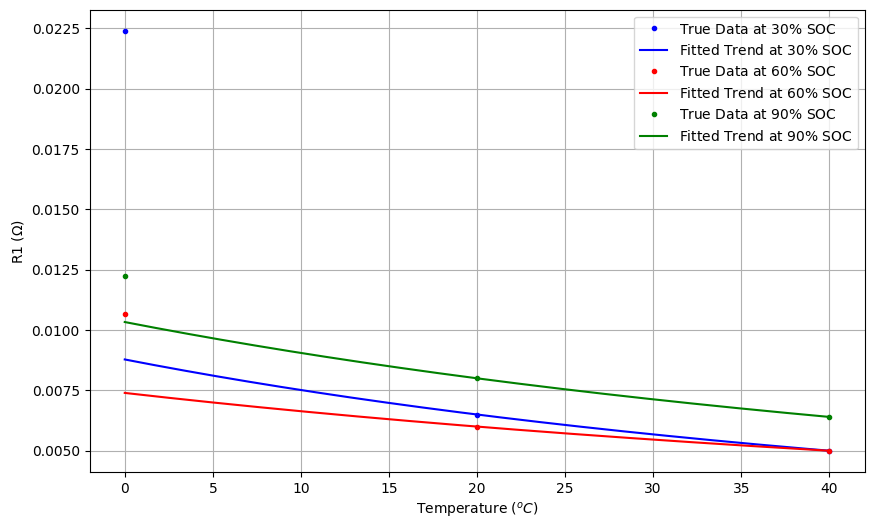

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, R1_true30, 'b.', label='True Data at $30\%$ SOC')
ax.plot(x_plot, y_pred30, 'b-', label='Fitted Trend at $30\%$ SOC')

ax.plot(x, R1_true60, 'r.', label='True Data at $60\%$ SOC')
ax.plot(x_plot, y_pred60, 'r-', label='Fitted Trend at $60\%$ SOC')

ax.plot(x, R1_true90, 'g.', label='True Data at $90\%$ SOC')
ax.plot(x_plot, y_pred90, 'g-', label='Fitted Trend at $90\%$ SOC')
ax.legend()
ax.set_xlabel('Temperature ($^oC$)')
ax.set_ylabel('R1 ($\Omega$)')
ax.grid()
fig.savefig('part3.9_last2fit.eps', format='eps')
plt.show()

#### Fit at each SOC through all points

In [27]:
T_fit = [0, 20, 40]

x_plot = np.linspace(0, 40, 500)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Fitted parameters:
E: -40823.404800656615


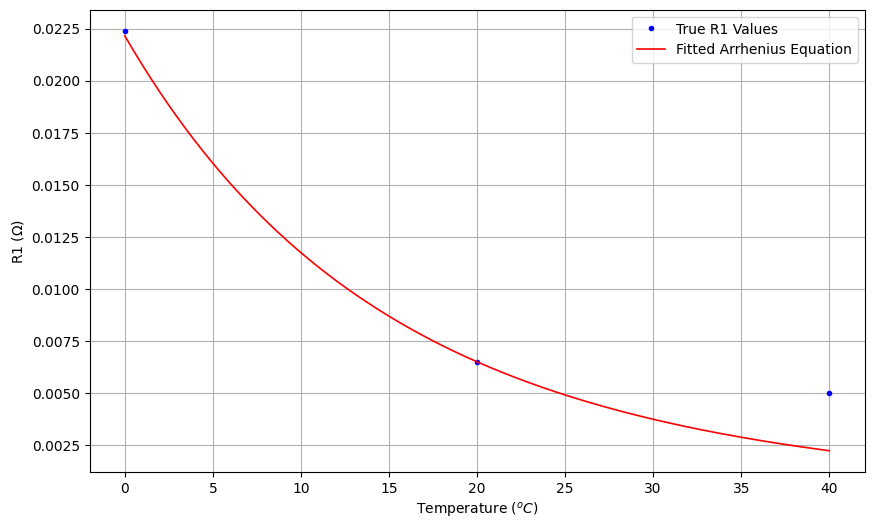

In [28]:
# SOC = 30%
R1_T0 = R1_tab[1, 6, idx_20]
def Arrhenius(T_fit, E):
    return R1_T0 * np.exp(- E/8.3145 * (1/(T_fit+273.15) - 1/(T0+273.15)))

y_true = R1_true30
my_func = Arrhenius
popts, _, _ = fit_RC(T_fit, y_true, my_func)

y_pred30 = Arrhenius(x_plot, *popts)

print('Fitted parameters:')
print('E:', popts[0])


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, R1_true30, 'b.', label='True R1 Values')
ax.plot(x_plot, y_pred30, 'r-', label='Fitted Arrhenius Equation', linewidth=1.2)
ax.legend()
ax.set_xlabel('Temperature ($^oC$)')
ax.set_ylabel('R1 ($\Omega$)')
ax.grid()
fig.savefig('part3.9_30soc.eps', format='eps')
plt.show()

Fitted parameters:
E: -17839.148216310547


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


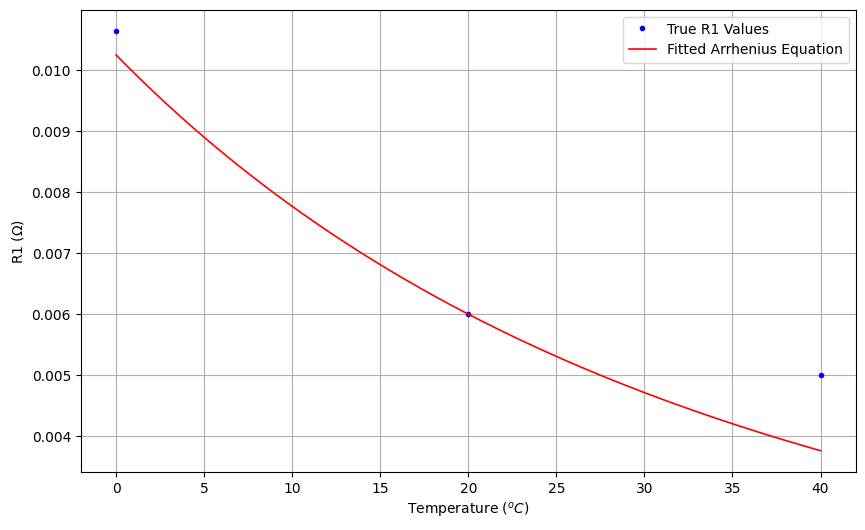

In [29]:
# SOC 60%
R1_T0 = R1_tab[1, 3, idx_20]
def Arrhenius(T_fit, E):
    return R1_T0 * np.exp(- E/8.3145 * (1/(T_fit+273.15) - 1/(T0+273.15)))

y_true = R1_true60
my_func = Arrhenius
popts, _, _ = fit_RC(T_fit, y_true, my_func)

y_pred60 = Arrhenius(x_plot, *popts)

print('Fitted parameters:')
print('E:', popts[0])


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, R1_true60, 'b.', label='True R1 Values')
ax.plot(x_plot, y_pred60, 'r-', label='Fitted Arrhenius Equation', linewidth=1.2)
ax.legend()
ax.set_xlabel('Temperature ($^oC$)')
ax.set_ylabel('R1 ($\Omega$)')
ax.grid()
fig.savefig('part3.9_60soc.eps', format='eps')
plt.show()

Fitted parameters:
E: -13323.7009289805


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


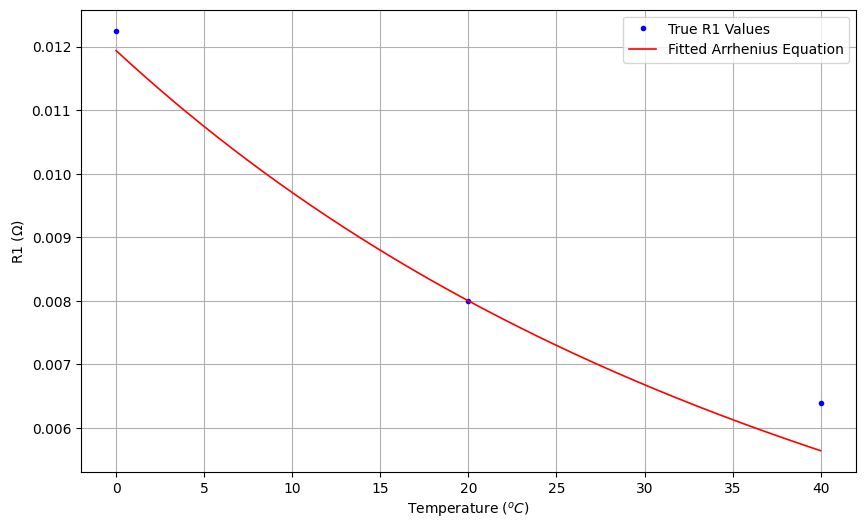

In [30]:
# SOC = 90%
R1_T0 = R1_tab[1, 0, idx_20]
def Arrhenius(T_fit, E):
    return R1_T0 * np.exp(- E/8.3145 * (1/(T_fit+273.15) - 1/(T0+273.15)))

y_true = R1_true90
my_func = Arrhenius
popts, _, _ = fit_RC(T_fit, y_true, my_func)

y_pred90 = Arrhenius(x_plot, *popts)

print('Fitted parameters:')
print('E:', popts[0])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, R1_true90, 'b.', label='True R1 Values')
ax.plot(x_plot, y_pred90, 'r-', label='Fitted Arrhenius Equation', linewidth=1.2)
ax.legend()
ax.set_xlabel('Temperature ($^oC$)')
ax.set_ylabel('R1 ($\Omega$)')
ax.grid()
fig.savefig('part3.9_90soc.eps', format='eps')
plt.show()

#### All SOCs in one plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


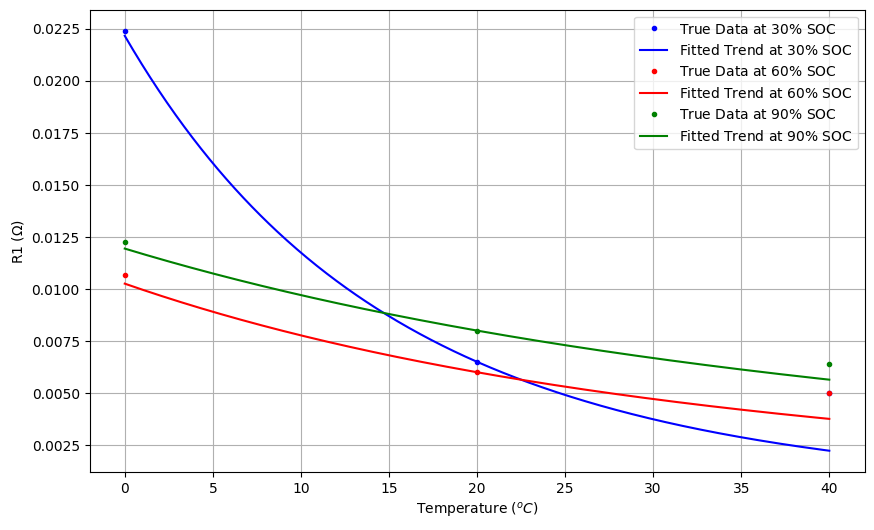

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, R1_true30, 'b.', label='True Data at $30\%$ SOC')
ax.plot(x_plot, y_pred30, 'b-', label='Fitted Trend at $30\%$ SOC')

ax.plot(x, R1_true60, 'r.', label='True Data at $60\%$ SOC')
ax.plot(x_plot, y_pred60, 'r-', label='Fitted Trend at $60\%$ SOC')

ax.plot(x, R1_true90, 'g.', label='True Data at $90\%$ SOC')
ax.plot(x_plot, y_pred90, 'g-', label='Fitted Trend at $90\%$ SOC')
ax.legend()
ax.set_xlabel('Temperature ($^oC$)')
ax.set_ylabel('R1 ($\Omega$)')
ax.grid()
fig.savefig('part3.9_fitall.eps', format='eps')
plt.show()